The PyNE `mesh` module is a part of the PyNE library, which provides functionalities for creating and manipulating generic meshes. It supports both cartesian and tetrahedral meshes. The meshes created using PyNE can be tagged with scalar and vector quantities, as well as PyNE `Material` objects. These tagged data can be easily accessed using a common syntax.

Internally, the PyNE `Mesh` class is a wrapper around a mesh library called [MOAB (Mesh Oriented datABase)](https://sigma.mcs.anl.gov/moab-library/). A `Mesh` object in PyNE stores a mesh instance from MOAB and also includes a PyNE `MaterialLibrary` object, which is used to map PyNE `Material`s to the volume elements of the mesh.

In this notebook, we will explore some basic examples of using PyNE meshes. We will begin by importing the necessary components from PyNE and other related libraries, which will be explained further in the notebook.

#### Known error: This notebook requires [yt](https://yt-project.org/) to visualize the results. Yt needs to be updated to work properly first. Updates are currently being made to yt's frontends to make this PyNE integration work.

In [1]:
# Import some classes from pyne.mesh
from pyne.mesh import Mesh, NativeMeshTag, MetadataTag, ComputedTag
from pyne.material import Material, from_atom_frac
from pyne.xs.channels import sigma_t
import numpy as np
import logging

# Disable all logging outputs
logging.disable(logging.CRITICAL)

# import plotting utilities
from yt.frontends.moab.api import PyneMoabHex8Dataset
from yt import SlicePlot

# Basics

Let's make a simple Cartesian mesh that is 4 x 3 x 1:

In [2]:
coords = [[0, 1, 2, 3, 4], [0, 1, 2, 3], [0,1]]
m = Mesh(structured=True, structured_coords=coords) # here "structured" means Cartesian

Tags, also referred to as fields, are utilized to store data on a mesh. PyNE `NativeMeshTags` enables the tagging of both scalar and vector quantities on each volume element of the mesh. Let's consider an example where we create a tag to represent the neutron flux on a mesh. This tag is a floating-point scalar value.

In [3]:
m.neutron_flux = NativeMeshTag(size=1, dtype=float)

The mesh can now be populated with fictitious neutron flux data.

In [4]:
m.neutron_flux[:] = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0]

PyNE meshes are supported by the [yt project](http://yt-project.org/).  Here we use yt's plotting infrastructure to display the mesh tag that was just created.


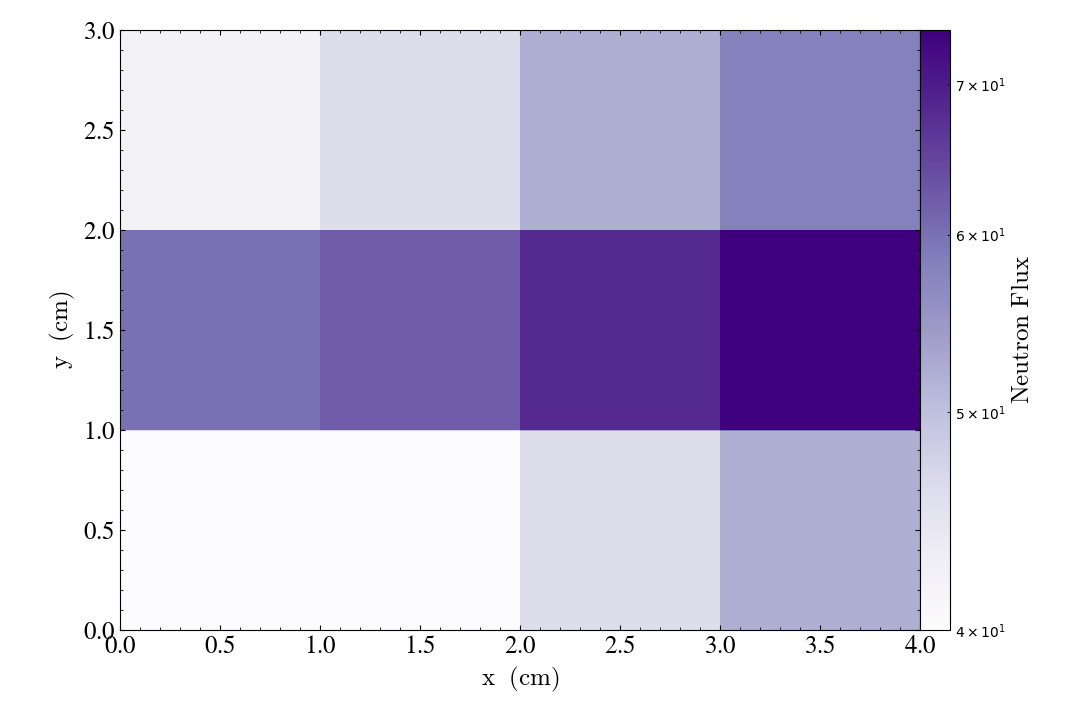

In [5]:
pf = PyneMoabHex8Dataset(m)
s = SlicePlot(pf, 'z', 'neutron_flux', origin='native')
s.set_cmap('neutron_flux', 'Purples')
s.display()

The volume elements within the mesh are kept track of using the volume element index (`i`). The volume element index is defined on the range from 0 (inclusive) to the number of volumes in the mesh (exclusive).

The flux for the volume element `i=7` can be retrieved (and similarly set) using the following syntax:

In [6]:
m.neutron_flux[7]

array([14.])

"Fancy" indexing can be used. This means that multiple indicies can be provided, yielding the tag value for each:

In [7]:
m.neutron_flux[2, 3, 4]

array([4., 6., 8.])

Masking can be used to return only values that match some criteria. Here, we request all flux values above 10.0.

In [8]:
m.neutron_flux[m.neutron_flux[:] >= 10.0]

array([10., 12., 14., 16., 18., 20., 22.])

# PyNE Mesh + PyNE Materials

In PyNE, meshes have the capability to natively store PyNE `Material` objects, which allows for the representation of discretized versions of geometries. To illustrate this, let's create a new mesh called `m2`, which is slightly larger than our previous example. Specifically, `m2` has dimensions of 9x9x1.

In [9]:
coords2 = [np.linspace(0,9,10), np.linspace(0,9,10), [0, 10]]
m2 = Mesh(structured=True, structured_coords=coords2)

Create a few materials that will be assigned to the mesh.

In [10]:
fuel = from_atom_frac({'U235': 0.045, 'U238': 0.955, 'O16': 2.0}, density=10.7)
mod = from_atom_frac({'H1': 2.0, 'O16': 1.0}, density=1.0)

Loop through the mesh and assign materials in a reactor-like pattern.

In [11]:
for i in range(len(m2)):
    if (i+1)%2 != 0 and np.floor((i)/9)%2 != 0:
        m2.mats[i] = fuel
    else:    
        m2.mats[i] = mod

Plot the density. Here, the fuel appears red (high density) and the moderator appears blue (low density).


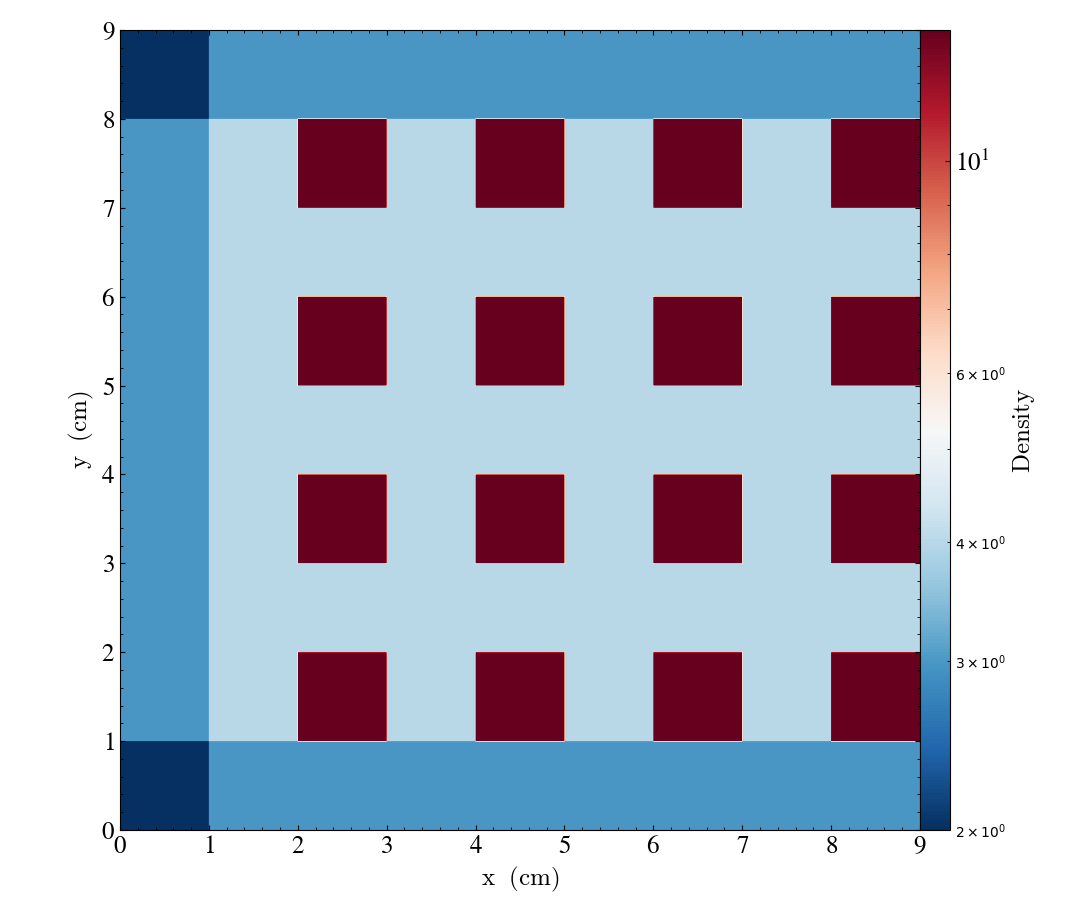

In [12]:
pf2 = PyneMoabHex8Dataset(m2)
s2 = SlicePlot(pf2, 'z', 'density', origin='native')
s2.set_cmap('density', 'RdBu_r')
s2.display()

The materials that we've added to the mesh can be accesssed via the same syntax used for `NativeMeshTags`. The material on the the mesh volume element with index `i=12` is retrieved.

In [13]:
print(m2.mats[12])

Material:
mass = 269.90530758893
density = 10.7
atoms per molecule = 3.0
mat_number = 13
name = 12
------------------------
O16    0.11852241634284943
U235   0.03918773166424315
U238   0.8422898519929074


The attributes of this material can be accessed.

In [14]:
m2.mats[12].density

10.7

Equivalently, the density can be accessed via the generic tag syntax.

In [15]:
m2.density[3]

1.0

The same is true of the composition of the material (another attribute of the `Material` class).

In [16]:
m2.comp[3]

{10010000: 0.11191487328888054, 80160000: 0.8880851267111195}

In fact, all `Material` attributes are treated as tags. A list of all tags, including these material properties treated as tags, is shown here:

In [17]:
for key, value in m2.tags.items():
    print(f"{value}")

NativeMeshTag: idx
MaterialPropertyTag: atoms_per_molecule
MaterialPropertyTag: metadata
MaterialPropertyTag: comp
MaterialPropertyTag: mass
MaterialPropertyTag: density
MaterialMethodTag: expand_elements
MaterialMethodTag: mass_density
MaterialMethodTag: molecular_mass
MaterialMethodTag: mult_by_mass
MaterialMethodTag: number_density
MaterialMethodTag: sub_act
MaterialMethodTag: sub_fp
MaterialMethodTag: sub_lan
MaterialMethodTag: sub_ma
MaterialMethodTag: sub_tru
MaterialMethodTag: to_atom_frac


# Advanced Feature: Computed Tags

A computed tag, also known as a derived field, is a method of creating a *virtual* tag within a system. Unlike regular tags, computed tags do not require the storage of tag data directly on the mesh or pre-computed values. Instead, computed tags calculate and return values on-the-fly when requested, using a technique known as lazy evaluation. This approach is particularly useful when dealing with large datasets.

To define a computed tag, you need to provide a function, lambda (also called an anonymous function), or any other callable object that meets the following interface requirements:

```python
def f(mesh, i):
    """mesh is a pyne.mesh.Mesh() object and i is the volume element index
    to compute.
    """
    # ... do some work ...
    return anything_you_want
```

Let's consider a playful example that involves the creation of a computed tag called `i_plus_density`. In this scenario, `i_plus_density` is derived by summing the index `i` of a mesh volume element with its corresponding density value. 

In [18]:
m2.i_plus_density = ComputedTag(lambda mesh, i: i + mesh.density[i])

Plotting `i_plus_density`:


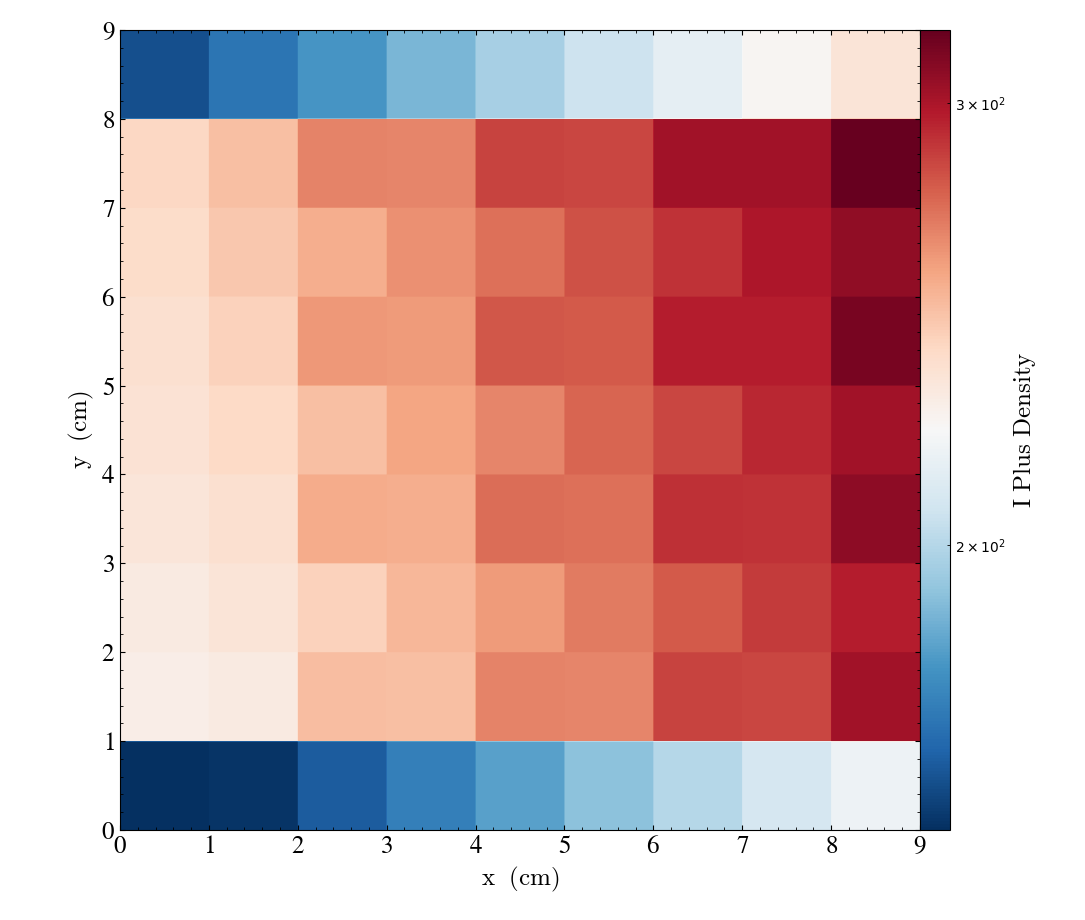

In [19]:
pf3 = PyneMoabHex8Dataset(m2)
s3 = SlicePlot(pf3, 'z', 'i_plus_density', origin='native')
s3.set_cmap('i_plus_density', 'RdBu_r')
s3.display()

Here is a more serious example which uses PyNE's cross section tools to compute the one-group total cross section $\sigma_t$ everywhere on the mesh.

In [20]:
m2.sigma_t = ComputedTag(lambda mesh, i: sigma_t(mesh.mats[i], group_struct=[10.0, 1e-6], phi_g=[1.0])[0])


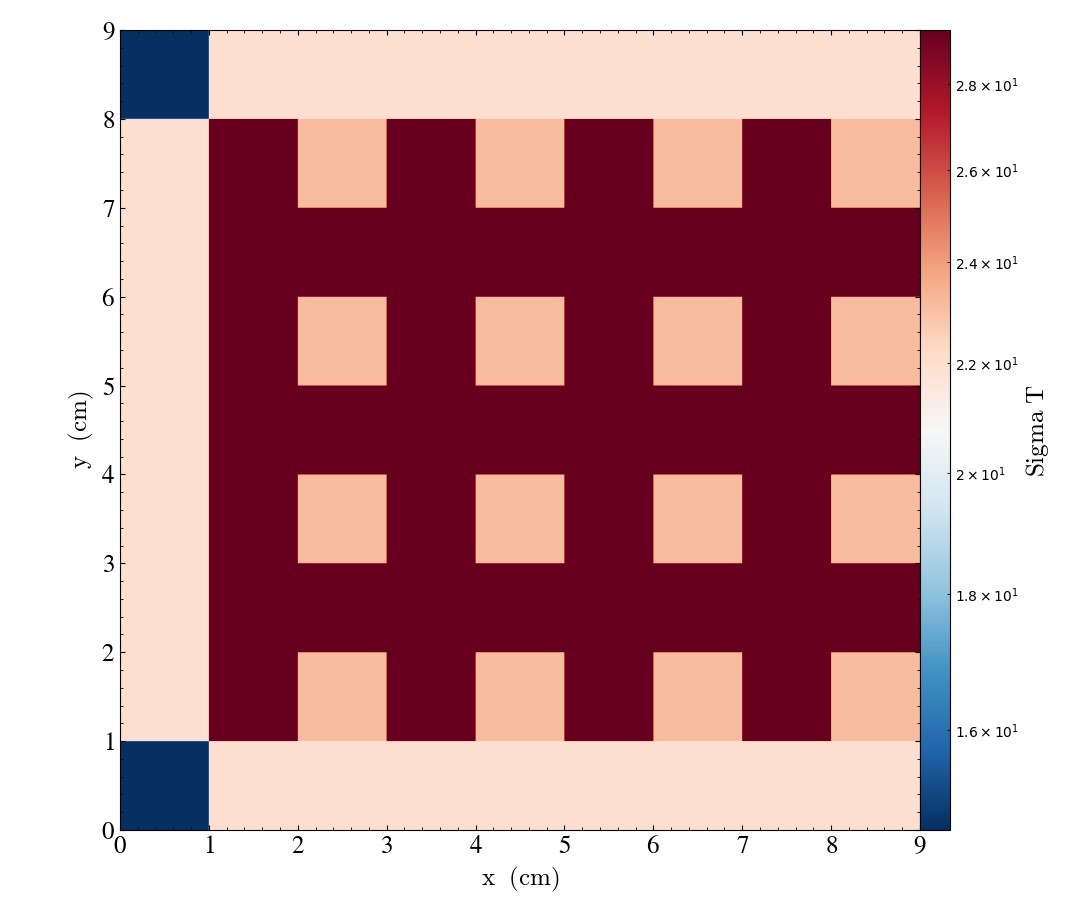

In [21]:
pf4 = PyneMoabHex8Dataset(m2)
s4 = SlicePlot(pf4, 'z', 'sigma_t', origin='native')
s4.set_cmap('sigma_t', 'RdBu_r')
s4.display()

This plot demonstrates that the one-group total cross section reaches its peak within the moderator. Remarkably, this insightful observation was generated using just a single line of code!